# Install Finesse

In [1]:
%%capture
!pip install finesse

# Import Finesse

In [2]:
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.configure(plotting=True)

## Michelson model

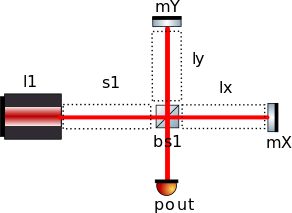

In [3]:
base = finesse.Model()
base.parse(
    """

    # Add a Laser named l1 with a power of 1 mega W.
    l l1 P=1M

    # Space attaching l1 <-> m1 with length of 1 m (default).
    s s1 l1.p1 bs1.p1 L=1

    # Beam splitter
    bs bs1 R=0.5 T=0.5 alpha=45

    # other two spaces
    s lx bs1.p3 mX.p1 L=4000
    s ly bs1.p2 mY.p1 L=4000

    # End mirrors
    m mX R=1 T=0
    m mY R=1 T=0

    """
)

In [4]:
michelson = base.deepcopy()
michelson.parse(
    """
    # Power detectors on reflection and transmission.
    pd pout bs1.p4.o
    xaxis(mX.phi, lin, 0, 360, 361)
    """
)

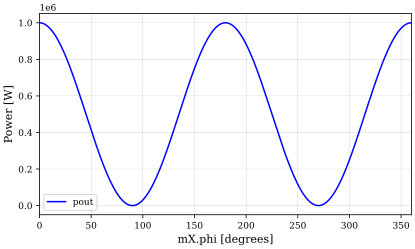

In [5]:
out = michelson.run()
out.plot();

# <font color='brown'> Question: What are we seeing here? And how we can shift the curve left/right? <font>
- As we move one of the mirrors, the relative phase between the light from the two arms changes and hence produces various levels of interference (going from constructive interference to destructive interference and so on).
- We need to set some intial offset(s) to one or both of the mirrors to shift the curve.

In [ ]:
michelson = base.deepcopy()
michelson.mY.phi=90
michelson.parse(
    """
    # Power detectors on reflection and transmission.
    pd pout bs1.p4.o
    xaxis(mX.phi, lin, 0, 360, 361)
    """
)
out = michelson.run()
out.plot();

## Response to gravitational waves

In [7]:
michelson = base.deepcopy()
michelson.parse(
    """
    fsig(1)
    sgen armx lx.h 1 0
    sgen army ly.h 1 180
    pd1 pout bs1.p4.o f=fsig.f
    # Sweep the frequency of the amplitude modulation
    xaxis(fsig.f, log, 1, 1e5, 2000)
    """
)

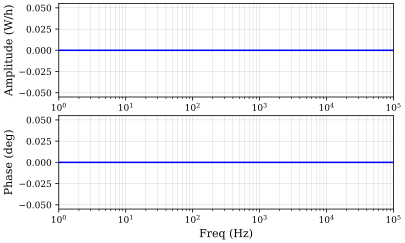

In [8]:
out = michelson.run()
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.semilogx(out.x[0], abs(out["pout"]))
ax2.semilogx(out.x[0], np.angle(out["pout"],deg=True))
ax1.set_ylabel('Amplitude (W/h)')
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Freq (Hz)')
plt.show()

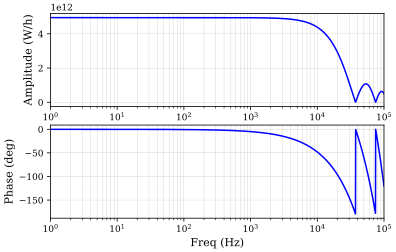

In [9]:
michelson.mY.phi=90.006
out = michelson.run()
H_s = abs(out["pout"])
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.semilogx(out.x[0], abs(out["pout"]))
ax2.semilogx(out.x[0], np.angle(out["pout"],deg=True))
ax1.set_ylabel('Amplitude (W/h)')
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Freq (Hz)')
plt.show()

# <font color='brown'> Question: <font>
- <font color='brown'> What are we seeing here i.e., how the response looks at low and high frequencies?  <font>

# <font color='brown'> Question: <font>
- <font color='brown'> The magnitude of the transfer function drops off as we go to higher frequencies, why?  <font>

## Sensitivity of gravitational wave detectors

### quantum noise

In [10]:
base = finesse.Model()
base.parse(
    """

    # Add a Laser named l1 with a power of 1 W.
    l l1 P=1M

    # Space attaching l1 <-> m1 with length of 1 m (default).
    s s1 l1.p1 bs1.p1 L=1

    # Beam splitter
    bs bs1 R=0.5 T=0.5 alpha=45

    # other two spaces
    s s2 bs1.p3 mX.p1 L=4000
    s s3 bs1.p2 mY.p1 L=4000

    # End mirrors
    m mX R=1 T=0 phi=0
    m mY R=1 T=0 phi=90.006

    """
)

In [11]:
ifo = base.deepcopy()
ifo.parse(
    """
    fsig(1)
    qshot shot_noise bs1.p4.o
    qnoised quant_noise bs1.p4.o
    # Sweep the frequency of the amplitude modulation
    xaxis(fsig.f, log, 1, 1e4, 2000)
    """
)

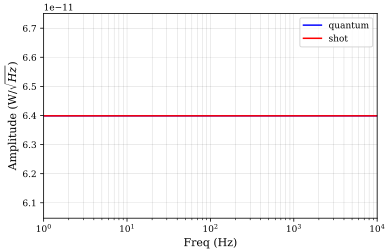

In [12]:
out = ifo.run()
plt.semilogx(out.x[0], abs(out["quant_noise"]),label='quantum')
plt.semilogx(out.x[0], abs(out["shot_noise"]),label='shot')
plt.ylabel('Amplitude (W/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

In [13]:
ifo = base.deepcopy()
ifo.parse(
    """
    free_mass mX_sus mX.mech mass=40
    free_mass mY_sus mY.mech mass=40
    fsig(1)
    qshot shot_noise bs1.p4.o
    qnoised quant_noise bs1.p4.o
    # Sweep the frequency of the amplitude modulation
    xaxis(fsig.f, log, 1, 1e4, 2000)
    """
)

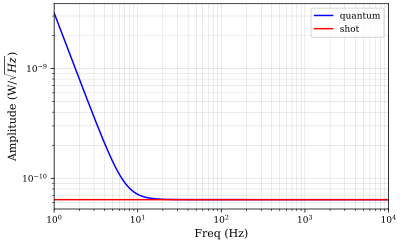

In [14]:
out = ifo.run()
plt.loglog(out.x[0], abs(out["quant_noise"]),label='quantum')
plt.loglog(out.x[0], abs(out["shot_noise"]),label='shot')
plt.ylabel('Amplitude (W/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

# <font color='blue'> TASK: Change the laser power to 25 W and see what happens to the shotnoise and quantum noise. <font>

## sensitivity TFs

For a noise source characterized by the noise spectral density $N_s$, the equivalent strain amplitude spectral density $S_s$ is given by

$$S_s(f) = \frac{N_s(f) |H_n(f)|}{|H_s(f)|}$$

where $H_n(f)$ is the transfer function from the corresponding noise to the output detector, and $H_s(f)$ is the transfer function of the gravitational wave signal to the output of the detector. The value $S_s$ tells us how much a particular noise appears to look like a gravitational wave signal, thus limits our sensitivity. For example for mirror motion due to seismic noise, the units of this work out as:

$$\frac{[m/\sqrt{Hz}] [W/m]}{[W/h]} = \frac{h}{\sqrt{Hz}}$$

For quantum nosie above, we acqually get $N_s(f) |H_n(f)|$, we to get the GW sensitivity we just have to divided by $H_s$ which is calculated above.


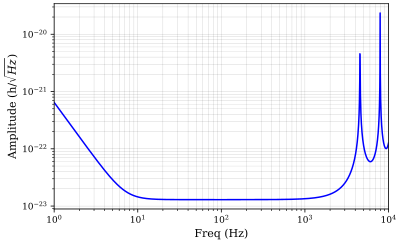

In [16]:
quantum = abs(out["quant_noise"])/H_s
shot = abs(out["shot_noise"])/H_s
freq = out.x[0]
plt.loglog(freq, quantum)
plt.ylabel('Amplitude (h/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.show()

## seismic noise

In [17]:
ifo = base.deepcopy()
ifo.parse(
    """
    free_mass mX_sus mX.mech mass=40
    free_mass mY_sus mY.mech mass=40
    fsig(1)
    sgen sig1 mX.mech.z 1 0
    pd1 seism_tf bs1.p4.o f=fsig.f
    xaxis(fsig.f, log, 1, 1e4, 2000)
    """
)

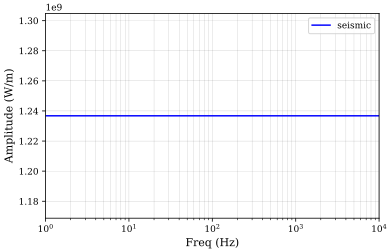

In [18]:
out = ifo.run()
seismic_tf = abs(out["seism_tf"])
plt.semilogx(out.x[0], abs(out["seism_tf"]),label='seismic')
plt.ylabel('Amplitude (W/m)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

In [19]:
def seismic_noise_ASD(f):
    f = np.array(f)
    N = 1e-4/np.abs(np.random.normal(f**15, 0, size=f.size))
    return N

N_s = seismic_noise_ASD(freq)
seismic = N_s * seismic_tf / H_s

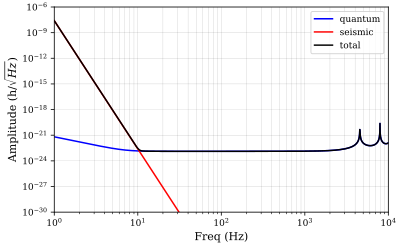

In [20]:
total = np.sqrt(quantum**2 + seismic**2)
plt.loglog(freq, quantum,label='quantum')
plt.loglog(freq, seismic,label='seismic')
plt.loglog(freq, total, label='total')
plt.ylabel('Amplitude (h/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.ylim([1e-30, 1e-6])
plt.legend()
plt.show()